## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

/Users/yinghuaz/anaconda3/envs/csci2470/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


### Define utils

In [4]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

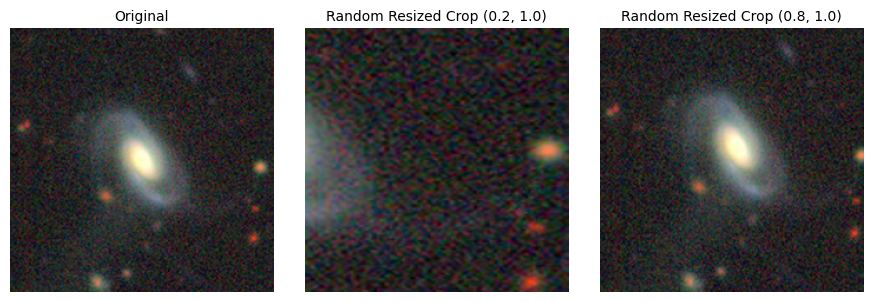

In [170]:
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# load image
img_path = '/Users/yinghuaz/Desktop/Main/Brown/csci2952x_ssl/hw1/mae/train/0/train_00001147.png'
img = Image.open(img_path)

# define RandomResizedCrop
random_crop02 = transforms.RandomResizedCrop(size=224, scale=(0.2, 1.0), interpolation=3)
random_crop08 = transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), interpolation=3)

# apply transforms
cropped_img02 = random_crop02(img)
cropped_img08 = random_crop08(img)

# convert to numpy
img_resized = np.array(img.resize((224, 224))) / 255.
cropped_img02_np = np.array(cropped_img02) / 255.
cropped_img08_np = np.array(cropped_img08) / 255.

# plot
plt.rcParams['figure.figsize'] = [9, 3]
fig, axs = plt.subplots(1, 3)

axs[0].imshow(img_resized)
axs[0].set_title("Original", fontsize=10)
axs[0].axis("off")

axs[1].imshow(cropped_img02_np)
axs[1].set_title("Random Resized Crop (0.2, 1.0)", fontsize=10)
axs[1].axis("off")

axs[2].imshow(cropped_img08_np)
axs[2].set_title("Random Resized Crop (0.8, 1.0)", fontsize=10)
axs[2].axis("off")

plt.tight_layout()
plt.show()


/var/folders/pt/rcylfn5556189_8r2160jhkc0000gn/T/ipykernel_85310/593299904.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


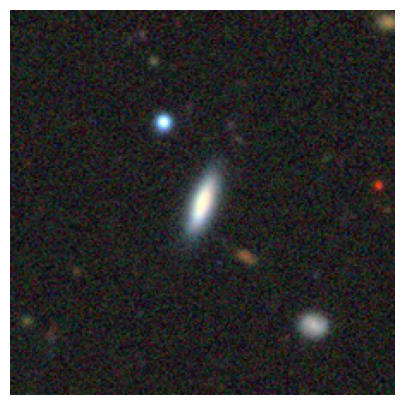

In [6]:
from torchvision import transforms

# load an image
img_path = '/Users/yinghuaz/Desktop/Main/Brown/csci2952x_ssl/hw1/mae/train/4/train_00000142.png'
img = Image.open(img_path)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [ ]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
#!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = '/users/yzhou392/scratch/mae-output_dir/checkpoint-240.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


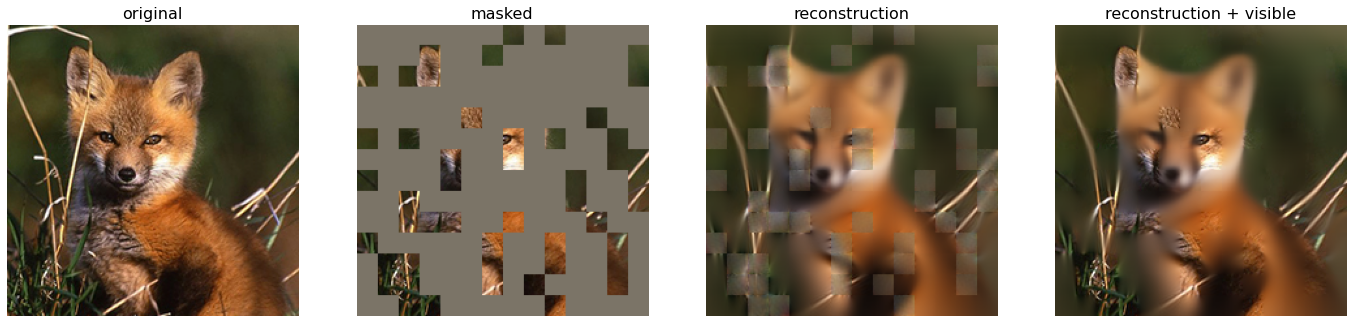

In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)